In [1]:
# EXECUTE THIS CELL
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit, brentq, fsolve
from scipy.interpolate import interp1d

import numpy as np
import sympy as sp
from sympy import Rational, symbols, simplify
from IPython.display import display, Math
import glob
import os

from ipywidgets import interact, FloatSlider

# Exercise 2: Phase Stability Analysis Using the Birch-Murnaghan Equation of State

Determine the phase transition pressure between coesite and quartz by analyzing their enthalpy as a function of pressure using the third-order Birch-Murnaghan Equation of State (BM-EOS).


The Birch-Murnaghan equation of state (BM-EOS) is widely used in materials science to describe the pressure-volume-energy relationship of solids under compression. 

You are given the third-order BM-EOS expression for pressure as a function of volume:

$$
P(V) = \frac{3B_0}{2} \left[ \left( \frac{V_0}{V} \right)^{7/3} - \left( \frac{V_0}{V} \right)^{5/3} \right] \cdot \left\{ 1 + \frac{3}{4}(B_0' - 4)\left[ \left( \frac{V_0}{V} \right)^{2/3} - 1 \right] \right\}
$$


You will use it to:

- Derive the energy–volume relation analytically.
- Compute the enthalpy for each phase.
- Identify the phase transition pressure by finding where the two enthalpy curves intersect.


For each phase, the following BM-EOS parameters are provided:

#### Coesite
- Equilibrium energy per atom: $E_0 = -10.542918 \, \mathrm{eV}/\text{atom}$  
- Equilibrium volume per atom: $V_0 = 11.376192 \, \mathrm{\AA}^3/\text{atom}$  
- Bulk modulus: $B_0 = 106.75 \, \mathrm{GPa}$  
- Pressure derivative of the bulk modulus: $B_0' = 1.059$

#### Quartz
- Equilibrium energy per atom: $E_0 = -10.555232 \, \mathrm{eV}/\text{atom}$  
- Equilibrium volume per atom: $V_0 = 12.464278 \, \mathrm{\AA}^3/\text{atom}$  
- Bulk modulus: $B_0 = 39.75 \, \mathrm{GPa}$  
- Pressure derivative of the bulk modulus: $B_0' = 5.339$



#### Units Matter:
- The bulk modulus $B_0$ is given in $\mathrm{GPa}$, but the equation internally assumes energy per unit volume.
- You must convert $B_0$ from $\mathrm{GPa}$ to $\mathrm{eV}/\mathrm{\AA}^3$ using:
  $$
  1 \, \mathrm{eV}/\mathrm{\AA}^3 = 160.21766208 \, \mathrm{GPa}
  $$
  Hence, to use the equation correctly:
  $$
  B_0\, [\mathrm{eV/\AA^3}] = \frac{B_0\, [\mathrm{GPa}]}{160.21766208}
  $$

## a) Derive $E(V)$ Analytically
   - Integrate the given expression for $P(V)$ with respect to $V$.
   - Use the provided $E_0$ values to fix the constant of integration.
   
From thermodynamics, pressure is related to energy by:

$$
P(V) = -\frac{dE}{dV}
$$

Therefore, to find $E(V)$, we integrate:

$$
E(V) = E_0 + \int_{V_0}^{V} -P(V') \, dV'
$$

Where $E_0$ is the energy at equilibrium volume $V_0$.


To perform the integration, we introduce the Eulerian strain $f$:

$$
f = \frac{1}{2} \left[ \left( \frac{V_0}{V} \right)^{2/3} - 1 \right]
$$

Expressing pressure in terms of $f$:

$$
P(f) = 3B_0 f (1 + 2f)^{5/2} \left[ 1 + \frac{3}{2}(B_0' - 4)f \right]
$$

Integrating $P(V)$ with respect to $V$ leads to the energy expression:

$$
E(V) = E_0 + \frac{9V_0B_0}{16} \left\{ \left[ \left( \frac{V_0}{V} \right)^{2/3} - 1 \right]^3 B_0' + \left[ \left( \frac{V_0}{V} \right)^{2/3} - 1 \right]^2 \left[ 6 - 4 \left( \frac{V_0}{V} \right)^{2/3} \right] \right\}
$$

This is the analytical expression for energy as a function of volume in the third-order BM-EOS.

### Alternative solution: using Python's SymPy library for symbolic mathematics

In [4]:
# Initialize pretty printing
sp.init_printing()

# Define symbols
V, V0, B0, B0p, E0 = sp.symbols('V V0 B0 B0p E0', positive=True)

# Define x using Rational to preserve the fraction
x = (V0 / V) ** Rational(1, 3)

# Define pressure P(V) with Rational constants
P = (Rational(3, 2) * B0) * (x**7 - x**5) * (1 + Rational(3, 4) * (B0p - 4) * (x**2 - 1))

# Compute energy E(V) by integrating -P with respect to V
E = E0 + sp.integrate(-P, V)

# Display the expression using LaTeX
# display(Math(sp.latex(E)))

# Simplify the expression
E_simplified = simplify(E)

# Display the expression using LaTeX
display(Math(sp.latex(E_simplified)))

<IPython.core.display.Math object>

### Define the Birch-Murnaghan Energy Function

After deriving $E(V)$ analytically, fill in the missing parts of the `birch_murnaghan_energy` function. 

Input the material-specific values, being mindful of their units.

Execute the cells, including the one that plots the Energy vs. Volume curves.

In [5]:
# Define the BM-EOS energy function
def birch_murnaghan_energy(V, E0, B0, B0p, V0):
    """
    Calculate energy E(V) using the third-order Birch-Murnaghan equation of state.

    Variable:
    V   : Volume
    Parameters:
    E0  : Equilibrium energy
    B0  : Bulk modulus
    B0p : Pressure derivative of the bulk modulus
    V0  : Equilibrium volume

    Returns:
    E   : Energy corresponding to volume V
    """

    # Compute eta and delta
    eta = (V0 / V) ** (2.0 / 3.0)
    delta = eta - 1.0

    # Compute energy using the BM-EOS formula
    E = E0 + (9.0 * V0 * B0 / 16.0) * (delta**3 * B0p + delta**2 * (6.0 - 4.0 * eta))
    
    return E

# Define system-specific parameters

# Parameters for coesite 
E0_c = -10.542918                # Equilibrium energy in eV/atom
V0_c = 11.376192                 # Equilibrium volume in Å³/atom
B0_c = 106.75 / 160.21766208      # Bulk modulus in eV/Å³
B0p_c = 1.059                    # Pressure derivative of the bulk modulus

# Parameters for quartz 
E0_q = -10.555232                # Equilibrium energy in eV/atom
V0_q = 12.464278                 # Equilibrium volume in Å³/atom
B0_q = 39.75 / 160.21766208      # Bulk modulus in eV/Å³
B0p_q = 5.339                    # Pressure derivative of the bulk modulus

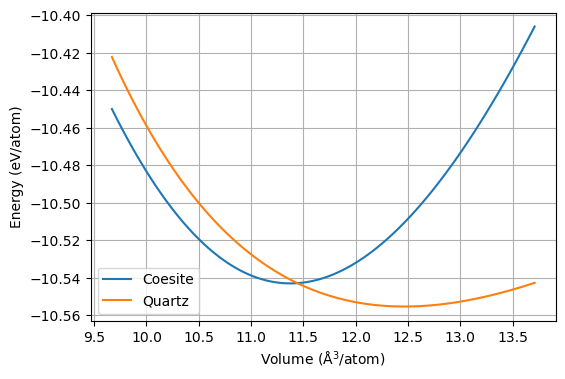

In [6]:
# Compute and plot energy vs. volume

# Define a range of volumes around the equilibrium volume
V_range = np.linspace(0.85 * min(V0_c, V0_q), 1.1 * max(V0_c, V0_q), 100)

# Calculate energies for each phase
E_c = birch_murnaghan_energy(V_range, E0_c, B0_c, B0p_c, V0_c)
E_q = birch_murnaghan_energy(V_range, E0_q, B0_q, B0p_q, V0_q)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(V_range, E_c, label='Coesite')
plt.plot(V_range, E_q, label='Quartz')
plt.xlabel('Volume ($\mathrm{\AA}^3$/atom)')
plt.ylabel('Energy (eV/atom)')

plt.legend()
plt.grid(True)

---

## b) Compute $H(V)$
   - For each phase, calculate enthalpy:
     $$
     H(V) = E(V) + P(V)\cdot V
     $$

### Define the Pressure Function $P(V)$:

Complete the function `birch_murnaghan_pressure` by filling in the missing parts.

Compute Enthalpy $H(V)$:
     $$
     H(V) = E(V) + P(V) \cdot V
     $$
   where $E(V)$ is `birch_murnaghan_energy` and $P(V)$ is `birch_murnaghan_pressure`.

Execute the cells, including the one that plots the enthalpy $H$ as a function of volume $V$ for both phases.

In [7]:
# Define the BM-EOS pressure function
def birch_murnaghan_pressure(V, B0, B0p, V0):
    """
    Calculate pressure P(V) using the third-order Birch-Murnaghan equation of state.

    Parameters:
    V   : Volume (array-like)
    B0  : Bulk modulus
    B0p : Pressure derivative of the bulk modulus
    V0  : Equilibrium volume

    Returns:
    P   : Pressure corresponding to volume V
    """

    eta = (V0 / V) ** (1.0 / 3.0)
    P = (3.0 * B0 / 2.0) * (eta**7 - eta**5) * (1.0 + (3.0 / 4.0) * (B0p - 4.0) * (eta**2 - 1.0))
    return P

In [8]:
# Define a range of volumes around the equilibrium volume
V_range = np.linspace(0.9 * min(V0_c, V0_q), 1.05 * max(V0_c, V0_q), 100)

# Calculate pressures and enthalpies for coesite
P_c = birch_murnaghan_pressure(V_range, B0_c, B0p_c, V0_c)
E_c = birch_murnaghan_energy(V_range, E0_c, B0_c, B0p_c, V0_c)

# Using the variables that have been defined so far, calculate enthalpy for coesite
H_c = E_c + P_c * V_range 


# Calculate pressures and enthalpies for quartz
P_q = birch_murnaghan_pressure(V_range, B0_q, B0p_q, V0_q)
E_q = birch_murnaghan_energy(V_range, E0_q, B0_q, B0p_q, V0_q)

# Using the variables that have been defined so far, calculate enthalpy for quartz
H_q = E_q + P_q * V_range   

---

## c) Plot Enthalpy vs. Pressure  
   - Plot both enthalpy curves $H(P)$ on the same graph.
   - Be mindful of the pressure units.

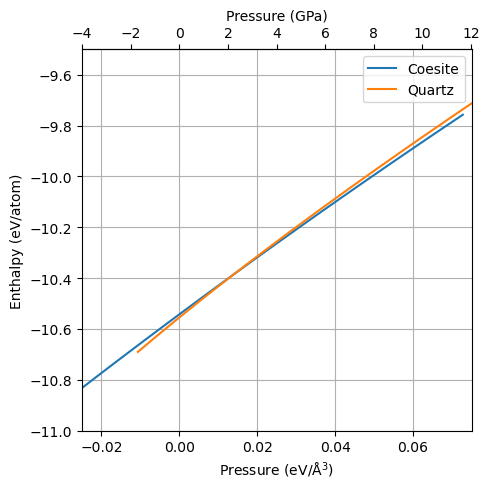

In [9]:
# conversion factor
eVA3_to_GPa = 160.21766208

# make the plot
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(P_c, H_c, label='Coesite')
ax.plot(P_q, H_q, label='Quartz')

ax.set_xlabel(r'Pressure (eV/$\mathrm{\AA}^3$)')
ax.set_ylabel('Enthalpy (eV/atom)')

ax.set_xlim(-0.025, 0.075)
ax.set_ylim(-11, -9.5)

ax.grid(True)
ax.legend()

# add a secondary x-axis on top in GPa
def to_GPa(x):
    return x * eVA3_to_GPa
def to_eVA3(x):
    return x / eVA3_to_GPa

secax = ax.secondary_xaxis('top', functions=(to_GPa, to_eVA3))
secax.set_xlabel('Pressure (GPa)')

plt.tight_layout()
plt.show()

---

## d) Determine the Transition Pressure

Identify the pressure at which the enthalpy curves of the two phases intersect. This pressure corresponds to the phase transition point.

**Hint**: You can find the intersection point by locating where the difference between `H_c` and `H_q` changes sign.

In [10]:
# Define a range of volumes around the equilibrium volume
V_range = np.linspace(0.9 * min(V0_c, V0_q), 1.05 * max(V0_c, V0_q), 100)

# Interpolate enthalpy as a function of pressure
H_c_interp = interp1d(P_c, H_c, kind='cubic', bounds_error=False, fill_value='extrapolate')
H_q_interp = interp1d(P_q, H_q, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Define a function for the difference in enthalpy
def delta_H(P):
    return H_c_interp(P) - H_q_interp(P)

# Find the pressure where delta_H crosses zero
P_min = max(min(P_c), min(P_q))
P_max = min(max(P_c), max(P_q))

try:
    P_transition = brentq(delta_H, P_min, P_max)
    print(f"Transition pressure: {P_transition*eVA3_to_GPa:.3f} GPa")
except ValueError:
    print("No intersection found in the specified pressure range.")

Transition pressure: 2.211 GPa


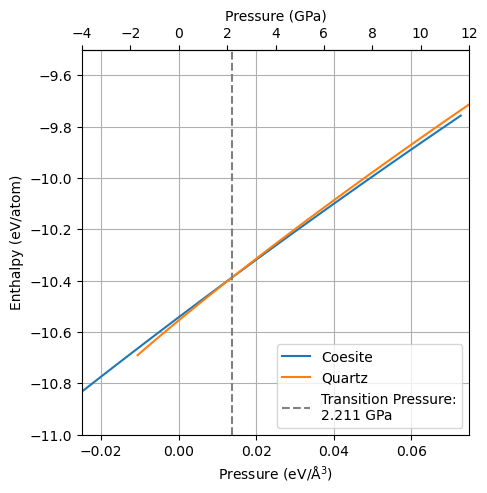

In [11]:
# make the plot
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(P_c, H_c, label='Coesite')
ax.plot(P_q, H_q, label='Quartz')
ax.axvline(P_transition, color='gray', linestyle='--', label=f'Transition Pressure:\n{P_transition*eVA3_to_GPa:.3f} GPa')

ax.set_xlabel(r'Pressure (eV/$\mathrm{\AA}^3$)')
ax.set_ylabel('Enthalpy (eV/atom)')

ax.set_xlim(-0.025, 0.075)
ax.set_ylim(-11, -9.5)

ax.grid(True)
ax.legend()
ax.set_xlim(-0.025, 0.075)

# add a secondary x-axis on top in GPa
def to_GPa(x):
    return x * eVA3_to_GPa
def to_eVA3(x):
    return x / eVA3_to_GPa

secax = ax.secondary_xaxis('top', functions=(to_GPa, to_eVA3))
secax.set_xlabel('Pressure (GPa)')

plt.legend()
plt.grid(True)
plt.show()

> Does it check out with what we know about the system?

<div style="text-align: center;">
    <img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-024-45840-9/MediaObjects/41467_2024_45840_Fig2_HTML.png?as=webp" width=500 align=left>
</div>

#### Do we get the same result with the common tangent construction?

To find the common‐tangent construction between two Birch–Murnaghan energy–volume curves $E_1(V)$ and $E_2(V)$, one needs to locate two volumes $V_1$ and $V_2$ (one on each curve) such that:

1. The slopes (pressures) are equal:
   $$
     P_1(V_1) = -\frac{\mathrm{d}E_1}{\mathrm{d}V}\Big|_{V_1}
     \;=\;
     P_2(V_2) = -\frac{\mathrm{d}E_2}{\mathrm{d}V}\Big|_{V_2}
   $$

2. The two tangent lines coincide (i.e., they have the same intercept):
   $$
     E_1(V_1) - P\,V_1 \;=\; E_2(V_2) - P\,V_2.
   $$

Once you have $V_1$, $V_2$ and the common slope (pressure) $P$, the tangent line is
$$
  E_{\rm tang}(V) \;=\; P\,V + c,
  \quad
  c = E_1(V_1) - P\,V_1.
$$



Define for each phase $i=1,2$:
- $E_i(V)$ and $P_i(V)$ as above.
- Unknowns $x = (V_1, V_2)$.

Then solve the system
$$
\begin{cases}
f_1(V_1,V_2) \;=\; P_1(V_1) - P_2(V_2) \;=\; 0,\\
f_2(V_1,V_2) \;=\; \bigl[E_1(V_1)-P_1(V_1)V_1\bigr]
              -\bigl[E_2(V_2)-P_2(V_2)V_2\bigr]
              \;=\; 0.
\end{cases}
$$

Once $(V_1,V_2)$ are found, the common pressure is 
$$
P = P_1(V_1) = P_2(V_2),
$$
and the intercept 
$$
c = E_1(V_1) - P\,V_1.
$$

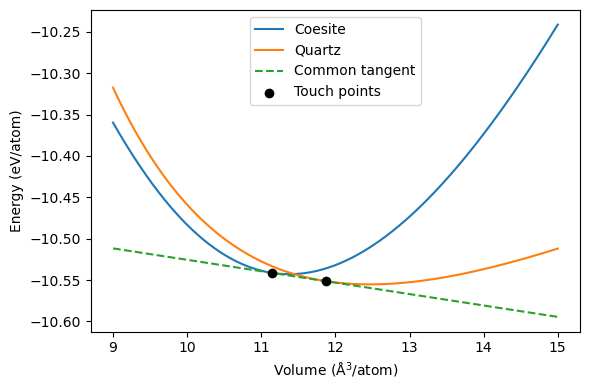

V₁ = 11.1454  Å³
V₂ = 11.8704  Å³
P  = 0.013798  eV/Å³  =  2.211  GPa


In [12]:
# ---------------- Symbols and Parameters -----------------
V1, V2 = sp.symbols('V1 V2', positive=True)
E0_c, V0_c, B0_c, B0p_c = sp.symbols('E0_c V0_c B0_c B0p_c')
E0_q, V0_q, B0_q, B0p_q = sp.symbols('E0_q V0_q B0_q B0p_q')

# ---------------- Symbolic Birch–Murnaghan -----------------
def E_BM_sym(V, E0, V0, B0, B0p):
    eta = (V0 / V)**(sp.Rational(2, 3)) - 1
    return E0 + 9 * V0 * B0 / 16 * (B0p * eta**3 + (6 - 4 * (1 + eta)) * eta**2)

E_c = E_BM_sym(V1, E0_c, V0_c, B0_c, B0p_c)
E_q = E_BM_sym(V2, E0_q, V0_q, B0_q, B0p_q)
P_c = -sp.diff(E_c, V1)
P_q = -sp.diff(E_q, V2)

# Common tangent conditions
eq1 = sp.Eq(P_c, P_q)
eq2 = sp.Eq(E_c + P_c * V1, E_q + P_q * V2)

# ---------------- Parameters -----------------
E0_c_val, V0_c_val, B0_c_val, B0p_c_val = -10.542918, 11.376192, 106.75 / 160.21766208, 1.059
E0_q_val, V0_q_val, B0_q_val, B0p_q_val = -10.555232, 12.464278, 39.75 / 160.21766208, 5.339

subs = {
    E0_c: E0_c_val, V0_c: V0_c_val, B0_c: B0_c_val, B0p_c: B0p_c_val,
    E0_q: E0_q_val, V0_q: V0_q_val, B0_q: B0_q_val, B0p_q: B0p_q_val
}

# ---------------- Solve -----------------
V1_star, V2_star = sp.nsolve((eq1.subs(subs), eq2.subs(subs)), (V1, V2), (11, 12))
P_star = float(P_c.subs({**subs, V1: V1_star}))
slope = -P_star

# Compute intercept from coesite point
c_star = birch_murnaghan_energy(float(V1_star), E0_c_val, B0_c_val, B0p_c_val, V0_c_val) + P_star * float(V1_star)

# ---------------- Plot -----------------
V_range = np.linspace(9, 15, 400)
E_c_vals = birch_murnaghan_energy(V_range, E0_c_val, B0_c_val, B0p_c_val, V0_c_val)
E_q_vals = birch_murnaghan_energy(V_range, E0_q_val, B0_q_val, B0p_q_val, V0_q_val)
tangent  = -P_star * V_range + c_star

plt.figure(figsize=(6, 4))
plt.plot(V_range, E_c_vals, label='Coesite')
plt.plot(V_range, E_q_vals, label='Quartz')
plt.plot(V_range, tangent, '--', label='Common tangent')
plt.scatter([float(V1_star), float(V2_star)],
            [birch_murnaghan_energy(float(V1_star), E0_c_val, B0_c_val, B0p_c_val, V0_c_val),
             birch_murnaghan_energy(float(V2_star), E0_q_val, B0_q_val, B0p_q_val, V0_q_val)],
            color='black', zorder=5, label='Touch points')
plt.xlabel('Volume ($\mathrm{\AA}^3$/atom)')
plt.ylabel('Energy (eV/atom)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Output -----------------
print(f"V₁ = {float(V1_star):.4f}  Å³")
print(f"V₂ = {float(V2_star):.4f}  Å³")
print(f"P  = {P_star:.6f}  eV/Å³  =  {P_star * 160.2177:.3f}  GPa")

---

# How do $B_0$ and $B_0'$ influence the shapes of $E(V)$ and $P(V)$?

## What Is $B_0$?

The parameter $B_0$ represents the **bulk modulus** of a material at its equilibrium volume $V_0$. It quantifies how resistant the material is to **uniform compression** — the higher the bulk modulus, the harder it is to compress the material.

Mathematically, it's defined as:

$$
B_0 = -V \left(\frac{dP}{dV}\right) \bigg|_{V = V_0}
$$

This expression describes the slope of the pressure–volume curve at equilibrium. The bulk modulus is also the **inverse of the compressibility**:

$$
\kappa = \frac{1}{B}
$$

So a small $\kappa$ (low compressibility) corresponds to a large $B_0$, meaning the material is stiff and resists volume change under pressure. Although $B_0$ is a constant in the equation of state, it’s really just **evaluated at $V_0$** — much like a coefficient in a Taylor expansion.



## What Is $B_0'$?

The parameter $B_0'$ is the **pressure derivative of the bulk modulus** at zero pressure:

$$
B_0' = \left(\frac{dB}{dP}\right)\bigg|_{P=0}
$$

In other words, it describes **how quickly the bulk modulus itself changes with pressure**. While $B_0$ tells us how stiff the material is at equilibrium, $B_0'$ tells us **how that stiffness evolves** as we compress the material further. Some materials stiffen rapidly under pressure — these have a high $B_0'$. Others may compress more gently and maintain a relatively constant stiffness — corresponding to a low $B_0'$.



### Why Do We Care About $B_0'$?

The Birch–Murnaghan equation of state is a **third-order** *expansion of energy or pressure in terms of strain*. The second-order version of the equation uses only $B_0$ and assumes that stiffness increases linearly with pressure. But real materials often deviate from this simple behavior, especially under significant compression.

Including $B_0'$ in the third-order formulation allows the model to **capture nonlinear stiffening effects** and fit experimental or computational data much more accurately at high pressure.

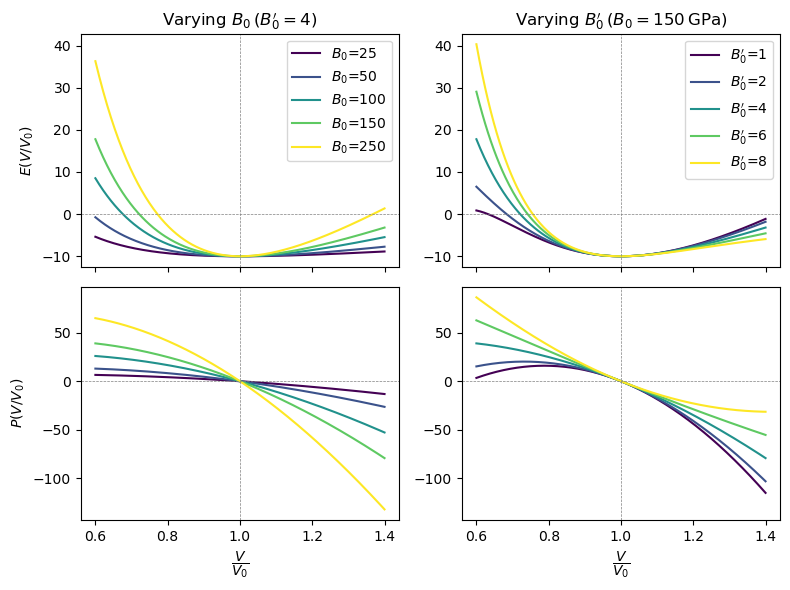

In [33]:
# Birch-Murnaghan 3rd order as function of x = V/V0
def birch_murnaghan_x(x, B0, B0_prime, E0):
    eta = x**(-2/3)
    E = E0 + (9 * B0 / 16) * ((eta - 1)**3 * B0_prime + (eta - 1)**2 * (6 - 4 * eta))
    P = 3 * B0 / 2 * (eta - 1) * eta**(-5/2) * (1 + 3/4 * (B0_prime - 4) * (eta - 1))
    return E, P

# Setup
E0 = -10.0
x = np.linspace(0.6, 1.4, 300)  # dimensionless V/V0

B0_values = [25, 50, 100, 150, 250]
B0_prime_values = [1, 2, 4, 6, 8]

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

cmap_B = plt.cm.viridis(np.linspace(0, 1, len(B0_values)))
cmap_Bp = plt.cm.viridis(np.linspace(0, 1, len(B0_prime_values)))

# E(x) for varying B0
for B0, color in zip(B0_values, cmap_B):
    E, _ = birch_murnaghan_x(x, B0, 4.0, E0)
    axes[0, 0].plot(x, E, label=f'$B_0$={B0}', color=color)
axes[0, 0].set_ylabel(r'$E(V/V_0)$')
axes[0, 0].set_title(r"Varying $B_0\,(B_0' = 4)$")
axes[0, 0].legend()

# E(x) for varying B0'
for B0_prime, color in zip(B0_prime_values, cmap_Bp):
    E, _ = birch_murnaghan_x(x, 150, B0_prime, E0)
    axes[0, 1].plot(x, E, label=f"$B_0'$={B0_prime}", color=color)
axes[0, 1].set_title("Varying $B_0'\,(B_0 = 150\,\\text{GPa})$")
axes[0, 1].legend()

# P(x) for varying B0
for B0, color in zip(B0_values, cmap_B):
    _, P = birch_murnaghan_x(x, B0, 4.0, E0)
    axes[1, 0].plot(x, P, label=f'$B_0$={B0}', color=color)
axes[1, 0].set_ylabel(r'$P(V/V_0)$')
axes[1, 0].set_xlabel(r'$\dfrac{V}{V_0}$')

# P(x) for varying B0'
for B0_prime, color in zip(B0_prime_values, cmap_Bp):
    _, P = birch_murnaghan_x(x, 150, B0_prime, E0)
    axes[1, 1].plot(x, P, label=f"$B_0'$={B0_prime}", color=color)
axes[1, 1].set_xlabel(r'$\dfrac{V}{V_0}$')

for ax in axes.flat:
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    ax.axvline(1.0, color='gray', lw=0.5, ls='--')  # x = 1 = V/V0

plt.tight_layout()
plt.show()

# What happens to the pressure?

In the **Birch–Murnaghan equation of state**, the pressure as a function of volume, $P(V)$, describes how the material resists compression or expansion away from equilibrium.

* When $V < V_0$, the material is **compressed**, and the pressure is **positive**.
* When $V > V_0$, the material is **expanded**, and the pressure becomes **negative** (tension).
* The curve is **nonlinear**, with the pressure rising sharply as volume decreases (strong resistance to compression), and flattening out more gently for expansion.

**The pressure vanishes at the equilibrium volume**, where the system is in mechanical equilibrium, not being compressed or stretched.

You can confirm this mathematically by evaluating $P(V)$ at $V = V_0$.

This is a built-in feature of the Birch–Murnaghan equation, which is constructed to match the behavior of a system at equilibrium.